In [2]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
import sentencepiece as spm
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split


#### archive

In [ ]:
# full_raw = pd.read_csv('/Users/javier/VSCODE/datahub/enron_data_fraud_labeled.csv') 

# filtered_raw = full_raw[['Body','Label']]

# filtered_raw.to_csv('full_sample.csv',index = False)

/var/folders/c9/rl6pcdvd1_xb6ng3n8l9wr2w0000gn/T/ipykernel_14999/1628828404.py:1: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  full_raw = pd.read_csv('/Users/javier/VSCODE/datahub/enron_data_fraud_labeled.csv')


In [ ]:
# test = "Hi John,  Please check out our new product at https://www.example.com/special-offer.  You can also visit www.testsite.org for more details.  I've attached the latest report as quarterly_results.pdf and also a backup copy as report.docx send to abc@gmail.com and john.doe@gmail.org. Let me know if you have trouble opening summary.xlsx.  Best,  Alice"

# html_text = """
# <html>
#   <head>
#     <title>Quarterly Update</title>
#   </head>
#   <body>
#     <h1>Special Offer!</h1>
#     <p>Dear customer,</p>
    
#     <p>
#       Please download the latest reports:
#       <a href="https://example.com/files/quarterly_report.pdf">Quarterly Report</a>,
#       <a href="https://example.com/files/summary.docx">Summary</a>,
#       and <a href="https://example.com/files/data.xlsx">Data File</a>.
#     </p>

#     <p>
#       If you cannot access the files, please email 
#       <a href="mailto:support@example.com">support@example.com</a>.
#     </p>

#     <p>
#       Alternatively, you may contact John at john.doe@workmail.org or visit our site 
#       <a href="http://www.testsite.org">www.testsite.org</a>.
#     </p>

#     <p>
#       Attached reference documents: <b>budget_2024.pdf</b>, <b>plan_final.docx</b>
#     </p>

#     <p>
#       loveeeeeeeeee
#       lovee33333eeee
#       a-p-p-l-e
#       b.a.n.a.n.a
#       fr33 c4$h 
#       Hello🌍!! This*** is a test 😎 #spam @user $100...
#       45 46 20000 32323 $222.22
#     </p
#   </body>
# </html>
# """


In [ ]:
# filtered_raw = pd.read_csv('/Users/javier/VSCODE/local/DSA4213_vsc/final_project/test.csv')
# print(filtered_raw.dtypes)


#### helpers

In [3]:
# masking special token
def mask_tokens(text):
    # replace URLs (http, https, www)
    text = re.sub(r'(https?://\S+|www\.\S+)', '<URL>', text)

    # replace common file extensions (customize list)
    text = re.sub(r'\b[\w\-]+\.(pdf|docx|xlsx|txt|csv|tar|doc\.gz|doc)\b', '<FILE>', text)

    # emails
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '<EMAIL>', text)

    # money 
    text = re.sub(r'\$\d+(?:\.\d{2})?','<MONEY>',text)

    # numbers 
    text = re.sub(r'\b\d+\b','<NUMBER>',text)
    text = text.replace('<NUMBER>', '')

    return text


# un HTML raw text 
def strip_html(raw_html):
    """
    Strip HTML tags, scripts, styles, and normalize whitespace
    to return clean raw text from HTML emails.
    """
    soup = BeautifulSoup(raw_html, "html.parser")

    
    for a in soup.find_all("a"):
        href = a.get("href",None)
        if not href:   # skip if no href
                continue

        # print(a_attribute)

        a_attribute = mask_tokens(href)

        if a_attribute == '<URL>' : 
            a.replace_with('<URL>')

        elif a_attribute =='<EMAIL>' : 
            a.replace_with('<EMAIL>')
        
        elif a_attribute == '<FILE>' : 
            a.replace_with('<FILE>')

        elif a_attribute == '<MONEY>' : 
            a.replace_with('<MONEY>')
        
        elif a_attribute == '<NUMBER>' : 
            a.replace_with('<NUMBER>')

    # remove script, style, head, and metadata tags
    for tag in soup(["script", "style", "head", "title", "meta", "[document]"]):
        tag.decompose()

    # extract text
    text = soup.get_text(separator=" ")

    # normalize unicode 
    text = unicodedata.normalize("NFKC", text)

    # replace non-breaking spaces specifically (unicode)
    text = text.replace("\xa0", " ")

    # collapse all whitespace tokens (line breaks, tabs, multiple spaces) into one space and remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # rim leading/trailing spaces
    return text

# special case handling
mapper = str.maketrans({
    '0':'o','1':'l','3':'e','4':'a','5':'s','7':'t','$':'s','@':'a'
})

def deobfuscate_words(text):
    """
    capture non-alphanumeric sequence in windows of 1-3 and replaces with ' ' 
    l-o-v-e -> l-o , - is detected and removed -> love
    """
    # replace text to number 
    text = text.translate(mapper)
    # remove weird spaces etc 
    text = re.sub(r'(?i)(?<=\w)[^A-Za-z0-9\s]{1,3}(?=\w)', '', text)
    return text

def word_capper(text):
    text = re.sub(r'(.)\1{' + str(2) + r',}', lambda m: m.group(1)*2, text)
    text = re.sub(r'([!?.,])\1{1,}', r'\1\1', text)
    return text


# whitelist filtering
def char_lvl_whitelist_filter(text): 
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\'\":;\-\_\(\)\@\#\$\%\^\&\<\>]', '', text)
    return text

# word level processor 
def lemmatizer(text) :
    lemmatizer = WordNetLemmatizer()
    sentence = ''

    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]

    return sentence.join(lemmatized_words)

#final clean
def final_punc_removal(text):
    text = re.sub(r'[^A-Za-z0-9\s<>]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

    
def preprocess_email_text(raw): 
    """
    the whole pipeline of processing
    input : dataframe with text column and ham/spam label
    output : dataframe with cleaned sentences and ham/spam label
    """
    raw = strip_html(raw) # process html first to capture links from <a> tags
    raw = mask_tokens(raw) # mask special tokens 
    raw = deobfuscate_words(raw)
    raw = word_capper(raw)
    raw = lemmatizer(raw)
    raw = char_lvl_whitelist_filter(raw)
    raw = final_punc_removal(raw)
    raw = raw.lower()
    return raw

def preprocess_email_df(df, text_col):
    df[text_col] = df[text_col].apply(preprocess_email_text)
    return df


def vocab_builder(
    input_df
    ,vocab_size
    ,model_type
) : 
    
    input_df["Body"].to_csv("emails_clean.txt", index=False, header=False)

    # train SentencePiece model
    spm.SentencePieceTrainer.Train(
        f"--input=emails_clean.txt "
        f"--model_prefix=email_sp "
        f"--vocab_size={vocab_size} "
        f"--character_coverage=1.0 "
        f"--model_type={model_type} "
        f"--shuffle_input_sentence=false "
        f"--seed_sentencepiece_size=1000000 "
        f"--user_defined_symbols=<url>,<email>,<file>,<money>,<pad>"
    )


def vocab_to_id_mapper(
        input_df
        ,max_len
) :
    
    sp = spm.SentencePieceProcessor()
    sp.load("email_sp.model")                 


    
    MAX_LEN = max_len
    pad_id = sp.piece_to_id("<pad>")
    if pad_id == -1:  
        pad_id = 0

    
    def encode_ids(text) :
        if not isinstance(text, str):
            text = "" if pd.isna(text) else str(text)
        return sp.encode_as_ids(text)

    def pad_ids(ids,max_len,pad_id) -> np.ndarray:
        if len(ids) >= max_len:
            return np.array(ids[:max_len], dtype=np.int32)
        return np.array(ids + [pad_id] * (max_len - len(ids)), dtype=np.int32)

    
    df = input_df.copy()
    df["sp_ids"] = df["Body"].apply(encode_ids)

    # overwrite sp_ids_padded with NumPy arrays directly
    df["sp_ids_padded"] = df["sp_ids"].apply(lambda ids: pad_ids(ids, MAX_LEN, pad_id))

    return df


def train_word2vec(
    input_df,
    vector_size: int = 300,
    window: int = 5,
    min_count: int = 5,
    epochs: int = 10,
    seed: int = 42
):
    
    sp = spm.SentencePieceProcessor()
    sp.load("email_sp.model")

    pad_id = sp.piece_to_id("<pad>")
    if pad_id == -1:
        pad_id = 0

    def ids_to_pieces(ids):
        return [sp.id_to_piece(i) for i in ids if i != pad_id]

    corpus_pieces = [ids_to_pieces(ids) for ids in input_df["sp_ids"]]

    w2v = Word2Vec(
        sentences=corpus_pieces,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=1,
        workers=1,   # keep reproducibility
        epochs=epochs,
        seed=seed
    )

    return w2v, sp, pad_id


def build_embedding_matrix(w2v, sp, pad_id: int, seed: int = 42):
    """
    Build embedding matrix aligned with SentencePiece IDs.
    """
    vocab_size = sp.get_piece_size()
    emb_dim = w2v.vector_size

    E = np.zeros((vocab_size, emb_dim), dtype=np.float32)
    rng = np.random.default_rng(seed)

    for sp_id in range(vocab_size):
        piece = sp.id_to_piece(sp_id)
        if piece in w2v.wv:
            E[sp_id] = w2v.wv[piece]
        else:
            E[sp_id] = rng.normal(0.0, 0.01, size=emb_dim).astype(np.float32)

    # Keep PAD = 0
    if 0 <= pad_id < vocab_size:
        E[pad_id] = 0.0

    metadata = {
        "vocab_size": vocab_size,
        "emb_dim": emb_dim,
        "pad_id": pad_id,
        "trained_vocab": len(w2v.wv),
        "oov_count": vocab_size - len(w2v.wv),
    }
    return E, metadata



#### word embeddign prepro

In [ ]:
# filtered_raw = pd.read_csv('/Users/javier/VSCODE/local/DSA4213_vsc/final_project/test.csv')
# debug_test = filtered_raw[['Body','Label']].iloc[:1]
# debug_test['Body'] = debug_test['Body'].apply(preprocess_email_text)
# print(type(debug_test))
# debug_test


<class 'pandas.core.frame.DataFrame'>


,Body,Label
0,status john im not really sure what happened b...,0


In [ ]:
## clean the text , save as variable to enable reuse
raw_df = debug_test

clean_df = preprocess_email_df(raw_df,'Body')

group_keys = ["Body"]
before = len(clean_df)
clean_df = clean_df.drop_duplicates(subset=group_keys,keep="first").reset_index(drop=True)
print(f"dedup removed: {before - len(clean_df)} | New shape: {clean_df.shape}")
# dedup removed: 219240 | New shape: (228177, 3)

clean_df.to_csv('../../../raw_data_untracked/clean_df.csv',index = False)

In [ ]:
## final project dims 
# vocab size = 50,000
# w2v vector size = 300
# max len = 256

In [38]:
clean_df = pd.read_csv('/Users/javier/VSCODE/local/DSA4213_vsc/final_project/raw_data_untracked/clean_df.csv')
clean_df.shape



(228177, 3)

In [ ]:
# vocab builder (ONLY CALL ONCE)
vocab_builder(clean_df,50_000,42,'bpe') #input, vocab, seed, subword model

In [ ]:
# map vocab to id
clean_df = pd.read_csv('/Users/javier/VSCODE/local/DSA4213_vsc/final_project/clean_df.csv')

mapped_df = vocab_to_id_mapper(clean_df,256) # input , seq len


In [ ]:
# call embedder
w2v_model, subword_processor, pad_id = train_word2vec(mapped_df)

# save model for reload
w2v_model.save('word2vec.model')

In [39]:
# build sp -> word embedin matrix 
load_path = 'colab_processed_models/full_220/'


# load saved model
w2v_model = Word2Vec.load(load_path+"word2vec.model")

#sentencePiece model & pad_id
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load(load_path+"email_sp.model")
pad_id = sp.piece_to_id("<pad>")
if pad_id == -1:
    pad_id = 0

subword_processor = sp 

embedding_matrix, embedding_summary = build_embedding_matrix(w2v_model,subword_processor,pad_id)

In [40]:
embedding_matrix

array([[ 0.00304717, -0.01039984,  0.00750451, ..., -0.00371915,
        -0.01756722,  0.00327995],
       [ 0.0172735 , -0.01533861,  0.00863828, ...,  0.00812601,
         0.0024166 , -0.01774962],
       [ 0.0051541 , -0.00577539,  0.01274447, ..., -0.00862318,
         0.00478876, -0.01535642],
       ...,
       [-0.14897132, -0.13138472, -0.1514239 , ..., -0.13885738,
         0.526286  , -0.40069607],
       [ 0.14660007,  0.17739818,  0.0375733 , ..., -0.19254978,
         0.5717467 , -0.09210922],
       [ 0.02365349, -0.05546646,  0.02987715, ..., -0.31438377,
         0.66288465, -0.03603499]], dtype=float32)

In [41]:
embedding_summary

{'vocab_size': 50000,
 'emb_dim': 300,
 'pad_id': 7,
 'trained_vocab': 47842,
 'oov_count': 2158}

In [42]:
pad_id = subword_processor.piece_to_id('<pad>')
pad_id

7

In [43]:
piece = "▁amount"   # example: a SentencePiece token

if piece in w2v_model.wv:
    for w, s in w2v_model.wv.most_similar(piece, topn=10):
        print(f"{w}\t{s:.4f}")
else:
    print("Piece not in vocab.")

▁amounts	0.6620
▁payment	0.5578
▁overdelivery	0.4874
▁stipulate	0.4854
▁fmv	0.4792
▁outlay	0.4762
▁unallocated	0.4653
▁determinable	0.4631
▁aggregate	0.4616
▁sum	0.4605


In [11]:
piece = "▁amount"   # example: a SentencePiece token

if piece in w2v_model.wv:
    for w, s in w2v_model.wv.most_similar(piece, topn=10):
        print(f"{w}\t{s:.4f}")
else:
    print("Piece not in vocab.")

▁amounts	0.6587
▁payment	0.5080
▁sum	0.4741
<money>	0.4455
▁stipulate	0.4436
▁excess	0.4394
▁quantity	0.4376
▁period	0.4343
▁payments	0.4338
▁aggregate	0.4327


#### encoder data prepro

In [3]:
raw_encoder_input = pd.read_csv('/Users/javier/VSCODE/local/DSA4213_vsc/final_project/raw_data_untracked/encoder_raw_data.csv')


In [13]:
raw_encoder_input.dtypes

text_combined    object
label             int64
dtype: object

##### train val test split

split here to ensure both pipeline get same split

In [4]:
SEED = 42

group_keys = ["text_combined"]
before = len(raw_encoder_input)
raw_encoder_input = raw_encoder_input.drop_duplicates(subset=group_keys,keep="first").reset_index(drop=True)
print(f"dedup removed: {before - len(raw_encoder_input)} | New shape: {raw_encoder_input.shape}")

dedup removed: 408 | New shape: (82078, 2)


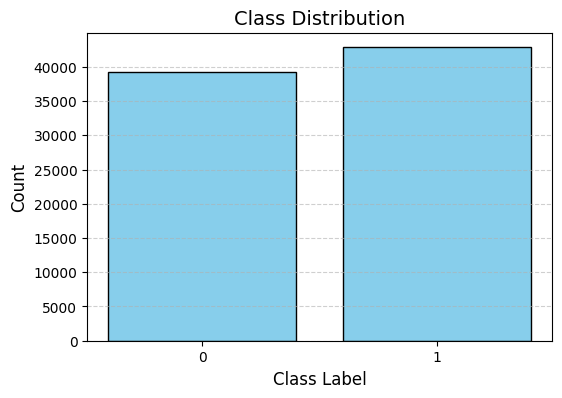

In [5]:
import matplotlib.pyplot as plt

# Count class frequencies
class_counts = raw_encoder_input['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values, color='skyblue', edgecolor='black')
plt.title("Class Distribution", fontsize=14)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [19]:
X = raw_encoder_input.index.values
y = raw_encoder_input['label'].astype(int).values

# 80% train 20% val+test
idx_train, idx_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# 10% val 10% test
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

train_df = raw_encoder_input.loc[idx_train].reset_index(drop=True)
val_df   = raw_encoder_input.loc[idx_val].reset_index(drop=True)
test_df  = raw_encoder_input.loc[idx_test].reset_index(drop=True)

In [20]:
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)



text_combined    object
label             int64
dtype: object
text_combined    object
label             int64
dtype: object
text_combined    object
label             int64
dtype: object
(65662, 2)
(8208, 2)
(8208, 2)


In [26]:
train_df.to_csv('../encoding/raw_encoder_data_sets/train_set.csv',index=False)
val_df.to_csv('../encoding/raw_encoder_data_sets/valid_set.csv',index=False)
test_df.to_csv('../encoding/raw_encoder_data_sets/test_set.csv',index=False)

In [27]:
print(len(set(val_df["text_combined"]) & set(test_df["text_combined"])))
print(len(set(val_df["text_combined"]) & set(train_df["text_combined"])))
print(len(set(test_df["text_combined"]) & set(train_df["text_combined"])))

0
0
0


### cross domain data prepro

In [26]:
cross_dom_raw = pd.read_csv('../../../raw_data_untracked/cross_domain_raw.csv',encoding = 'latin1')
cross_dom_raw.shape
cross_dom_raw.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [27]:
cross_dom_process = cross_dom_raw[['v2','v1']]
cross_dom_process.rename(columns = {'v2':'original_text'},inplace=True)
cross_dom_process['label'] = cross_dom_process['v1'].map({'ham': 0, 'spam': 1}).astype(int)
cross_dom_process = cross_dom_process.drop(columns=['v1'])
cross_dom_process

/var/folders/c9/rl6pcdvd1_xb6ng3n8l9wr2w0000gn/T/ipykernel_52611/1060591425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_dom_process.rename(columns = {'v2':'original_text'},inplace=True)
/var/folders/c9/rl6pcdvd1_xb6ng3n8l9wr2w0000gn/T/ipykernel_52611/1060591425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_dom_process['label'] = cross_dom_process['v1'].map({'ham': 0, 'spam': 1}).astype(int)


,original_text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [28]:
cross_dom_process['cleaned'] = cross_dom_process['original_text'].apply(preprocess_email_text)


In [ ]:
group_keys = ["cleaned"]
before = len(cross_dom_process)
cross_dom_clean = cross_dom_process.drop_duplicates(subset=group_keys,keep="first").reset_index(drop=True)
print(f"dedup removed: {before - len(cross_dom_clean)} | New shape: {cross_dom_clean.shape}")

dedup removed: 479 | New shape: (5093, 3)


In [31]:
cross_dom_clean = cross_dom_clean[['original_text','cleaned','label']]
cross_dom_clean.to_csv('../../../raw_data_untracked/cross_domain_clean.csv',index = False)
cross_dom_clean

,original_text,cleaned,label
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,0
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,1
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,0
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,0
...,...,...,...
5088,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried contact u u...,1
5089,Will Ì_ b going to esplanade fr home?,will b going to esplanade fr home,0
5090,"Pity, * was in mood for that. So...any other s...",pity was in mood for that soany other suggestions,0
5091,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like id ...,0
